# Regressão Linear com Vendas de Suco de Laranja

## 1. Seleção

O dataset utilizado contém as quantidades de vendas de suco de laranja de um determinado supermercado em Belém ao decorrer de 2023.

A importação dos dados foi feita usando a função read_csv da biblioteca **pandas**

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
sales_suco = pd.read_csv('../data/sales_suco.csv', index_col='DATE',parse_dates=True)

In [21]:
sales_suco.head()

,COUNT
DATE,
2023-01-01,0
2023-01-02,79
2023-01-03,71
2023-01-04,80
2023-01-05,118


Para a melhor compreensão do dataset foi usado a função **describe**, que gera algumas estatísticas das colunas, e a função **info**, que fornece informações essenciais, como o tipo de dado das colunas e a quantidade de dados nulos.

In [22]:
sales_suco.describe()

,COUNT
count,365.000000
mean,99.430137
std,55.493428
min,0.000000
25%,75.000000
50%,96.000000
75%,128.000000
max,395.000000


In [23]:
sales_suco.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2023-01-01 to 2023-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   COUNT   365 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB


# 2. Pré-processamento

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

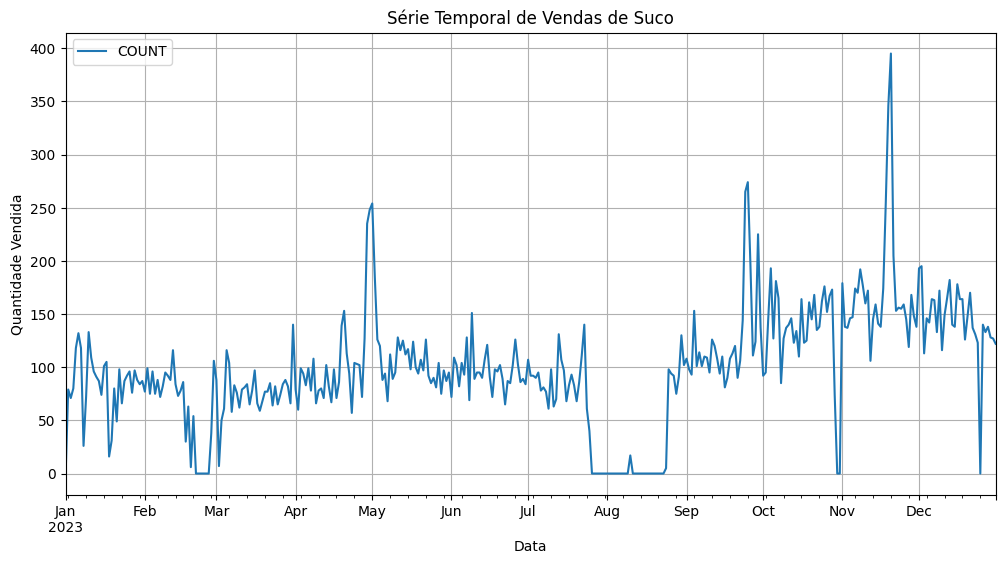

In [25]:
sales_suco.plot(figsize=(12, 6))
plt.title('Série Temporal de Vendas de Suco')
plt.xlabel('Data')
plt.ylabel('Quantidade Vendida')
plt.grid()
plt.show()

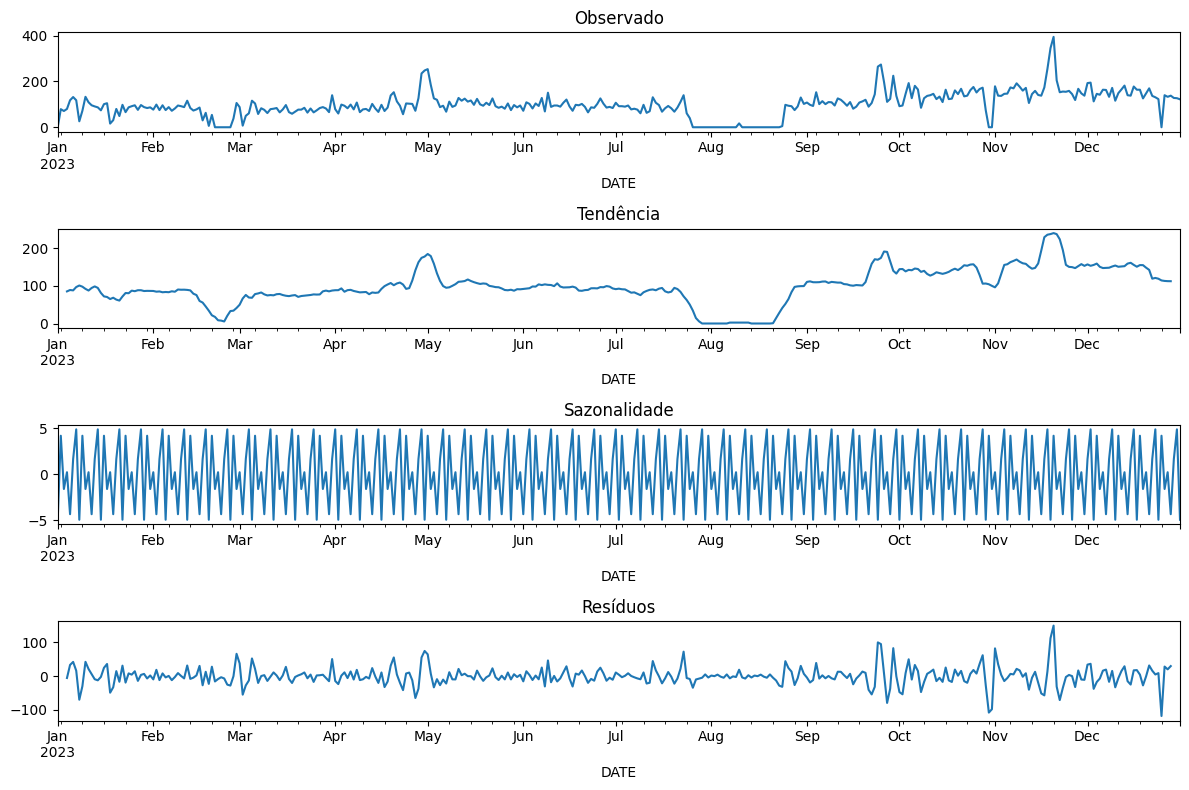

In [26]:
result = seasonal_decompose(sales_suco)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))

result.observed.plot(ax=ax1)
ax1.set_title('Observado')

result.trend.plot(ax=ax2)
ax2.set_title('Tendência')

result.seasonal.plot(ax=ax3)
ax3.set_title('Sazonalidade')

result.resid.plot(ax=ax4)
ax4.set_title('Resíduos')

plt.tight_layout()

Não foi preciso aplica nenhum método para o tratamento de dados faltosos, já que o dataset não possui nenhuma ocorrência de dados nulos.

In [27]:
print(f'Quantidade de dados nulos: {sales_suco.isna().sum().values[0]}')

Quantidade de dados nulos: 0


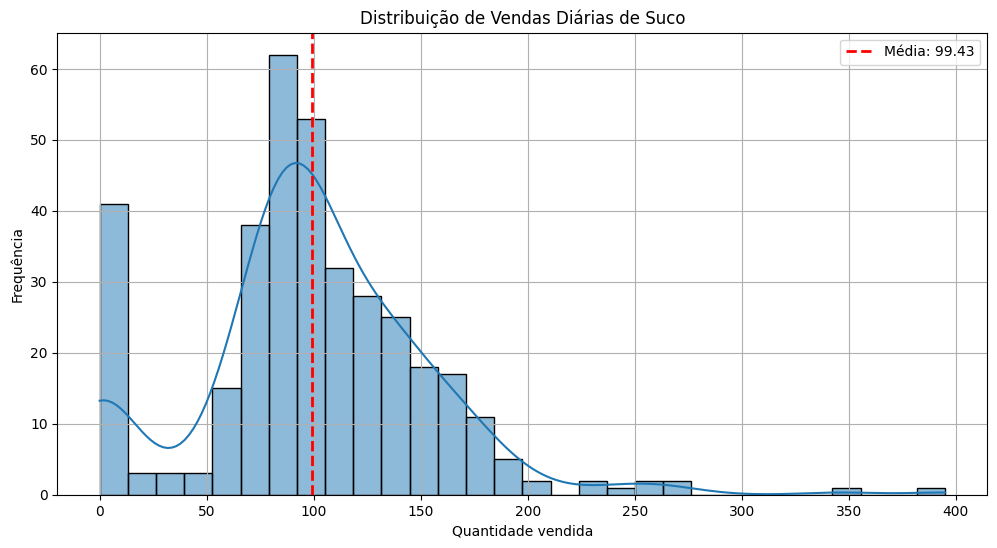

In [29]:
plt.figure(figsize=(12, 6))
sns.histplot(sales_suco['COUNT'], bins=30, edgecolor='k', kde=True)
plt.title('Distribuição de Vendas Diárias de Suco')
plt.xlabel('Quantidade vendida')
plt.ylabel('Frequência')
plt.grid()

media_vendas = sales_suco['COUNT'].mean()
plt.axvline(media_vendas, linestyle='--', color='red', label=f'Média: {media_vendas:.2f}', linewidth=2)

plt.legend()
plt.show()

Através do gráfico de boxplot foi possível identificar a existência de 9 possíveis outliers.

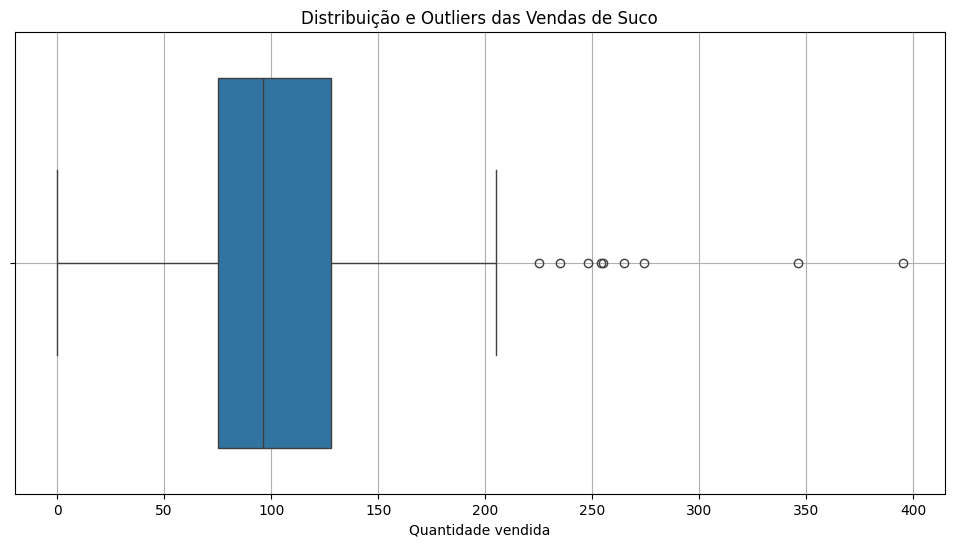

In [30]:
plt.figure(figsize=(12, 6))

sns.boxplot(x=sales_suco['COUNT'])
plt.title('Distribuição e Outliers das Vendas de Suco')
plt.xlabel('Quantidade vendida')
plt.grid()
plt.show()

Para a remoção de possíveis outliers foi usado o método de **Intervalo Interquartil (IQR)**.

In [31]:
q1 = sales_suco['COUNT'].quantile(0.25)
q3 = sales_suco['COUNT'].quantile(0.75)
iqr = q3 - q1

sales_suco = sales_suco[(sales_suco['COUNT'] > q1 - iqr * 1.5) & (sales_suco['COUNT'] < q3 + iqr * 1.5)]

O resultado foi a remoção de **9 entradas**, visto que depois da aplicação do IQR a quantidade de linhas caiu para 356.

In [32]:
sales_suco.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 356 entries, 2023-01-01 to 2023-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   COUNT   356 non-null    int64
dtypes: int64(1)
memory usage: 5.6 KB


In [33]:
sales_suco.to_csv("../data/sales_suco_cleaned.csv")

# 3. Transformação

Será criada uma nova feature, uma variável defasada no tempo, que será usada para prever a quantidade de vendas de suco de laranja.

Uma váriavel defasada no tempo é um valor de período anterior utilizada para prever valores futuros.

A nova feature "vendas_ontem" possui valores das vendas do dia anterior e será usada para prever a quantidade de vendas do dia seguinte.

In [34]:
sales_suco_cleaned = pd.read_csv('../data/sales_suco_cleaned.csv', parse_dates=True)

In [35]:
sales_suco_cleaned['vendas'] = sales_suco_cleaned['COUNT'].shift(-1)
sales_suco_cleaned.rename(columns={'DATE': 'data', 'COUNT':'vendas_ontem'}, inplace=True)
sales_suco_cleaned.set_index('data', inplace=True)

In [36]:
sales_suco_cleaned.dropna(inplace=True)

In [37]:
sales_suco_cleaned.to_pickle('../data/sales_suco_transformed.pkl')

# 4. Mineração de Dados

Para a etapa de mineração de dados será usada a regressão linear da biblioteca **scikit-learn** e uma **regressão linear manual**.

In [38]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [40]:
sales_suco_transformed = pd.read_pickle('../data/sales_suco_transformed.pkl')

,vendas_ontem,vendas
data,,
2023-01-01,0,79.0
2023-01-02,79,71.0
2023-01-03,71,80.0
2023-01-04,80,118.0
2023-01-05,118,132.0
...,...,...
2023-12-26,140,133.0
2023-12-27,133,138.0
2023-12-28,138,128.0


In [41]:
reg_lin_sklearn = LinearRegression()
reg_lin_sklearn.fit(X=sales_suco_transformed[['vendas_ontem']], y=sales_suco_transformed['vendas'])

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [42]:
def linear_regression(X, y):
    
    X = np.array(X).reshape((-1))
    y = np.array(y).reshape((-1))

    intercept_vals = np.arange(1, 255, 1)
    coef_vals = np.arange(0, 5, 0.1)
    best_sae = 10000

    for intercept in intercept_vals:
        for coef in coef_vals:
            y_pred = intercept + coef * X
            sae = np.abs(y_pred - y).sum()
            if sae < best_sae:
                best_sae = sae
                best_intercept = intercept
                best_coef = coef

    return (float(best_intercept), float(best_coef))


In [43]:
intercept, coef = linear_regression(sales_suco_transformed['vendas_ontem'], sales_suco_transformed['vendas'])

In [44]:
y_pred_sklearn = reg_lin_sklearn.predict(sales_suco_transformed[['vendas_ontem']])

In [45]:
y_pred = intercept + coef * sales_suco_transformed['vendas_ontem']

# 5. Avaliação

Para a avaliação do desempenho dos dois modelos foi feito uma gráfico que compara a reta resultado da regressão linear do scikit-learn e a reta resultado da regressão linear manual.

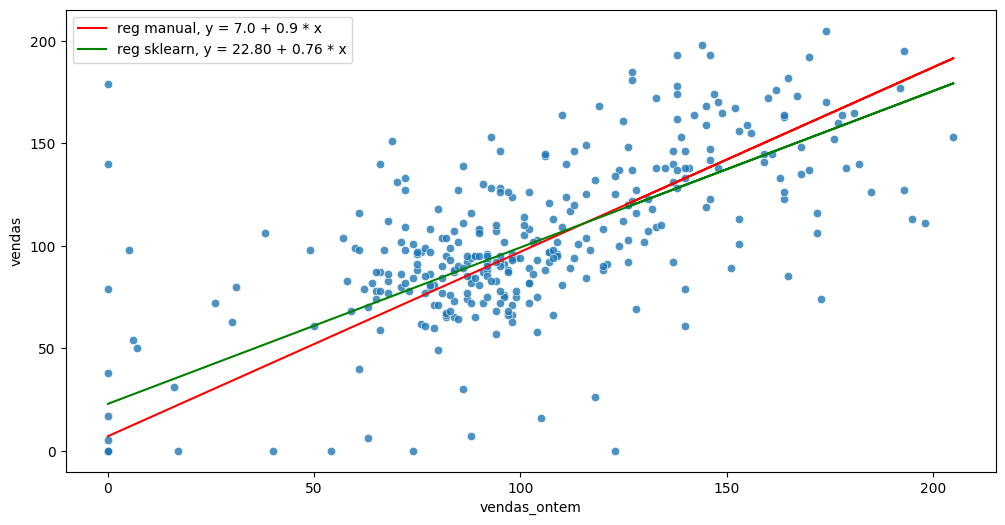

In [47]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='vendas_ontem', y='vendas', data=sales_suco_transformed, alpha=0.8)
plt.plot(sales_suco_transformed['vendas_ontem'], y_pred, color='red', label=f'reg manual, y = {intercept} + {coef} * x')
plt.plot(sales_suco_transformed['vendas_ontem'], y_pred_sklearn, color='green', label=f'reg sklearn, y = {reg_lin_sklearn.intercept_:.2f} + {reg_lin_sklearn.coef_[0]:.2f} * x')
plt.legend()